In [94]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

# Overscan/Flats
###### possibly do bias later but may have enough s/n without

In [95]:
#changing plt default fig size to better show spectrums when i get that far
plt.rcParams['figure.figsize'] = (16, 10)

#setting up dimensions based on ccd size per specs on website
redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

In [96]:
#removing overscan from flats? idk where bias frames are tho

#'DomeFlat' is an object label telling it to look for
#tells to run reduce_dblspec on last 10 files ending in filename ext (with *)
rflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat','20170518/red*.fits')[:10]] 

#creating normalized flats - ie just instrument noise not from readout
rnfl = reduce_dblspec.create_normalized_flat(rflats)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


##### wheres combine exposures / rejecting cosmics step? maybe dont really need unless spot in a spectra somewhere crucial 

## Dispersion Solutions

#### Procedure:

#### 1. create a `DispersionSolution` object with the relvant arc
#### 2. compare to the atlas and match up lines
#### 3. use guess_plot to refine the line location (and ID the line list wl)
#### 4. once enough are populated, use `guess_from_line_list` to get the remainder

In [97]:
#wait this fcn is created in NB but never used - why? - work on understanding it later then


#creating a fcn that will guess the matching line peaks btwn (arcs or data?) & atlas
#guessing plot btwn pixels and wavelength
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset #whats ds? #how linelist diff from wlatlas & specatlas?
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec()
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas)
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists
    
#use e.g. guess_plot(3372, 9658, (rds, redwlnoao, redspecnoao, reduce_dblspec.HENEAR_LINE_LIST))

In [98]:
#Redside cam setup

#opening and locating the HeNeAr well know spec lines via atlas
redatlas = fits.open('henear.fits') #NOAO atlas
h = redatlas[0].header
redspecnoao = redatlas[0].data

#maybe matching atlas known spec lines to wavelength - see more info in comments on blueside cam
redwlnoao = h['CRVAL1'] + h['CD1_1']*(np.arange(len(redspecnoao)) - h['CRPIX1'] + 1) #+1 is for 0-based
#CRVAL1 = 3296.2763671875 #CD1_1 = 0.34725826978683 #CRPIX1 = 1.
h

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                  -32  /  FITS BITS/PIXEL                              
NAXIS   =                    1  /  NUMBER OF AXES                               
NAXIS1  =                23642  /                                               
OBJECT  = 'henear 3500A'        /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '26-07-96'            /                                               
IRAFNAME= 'henear.spec'         /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           3.591000E3  /  DATA MAX                                     
IRAF-MIN=           7.530000E2  /  DATA MIN                                     
IRAF-BPX=                   32  /  DATA BITS/PIXEL                              
IRAFTYPE= 'REAL    '            /  PIXEL TYPE                                   
OBSERVAT= 'KPNO             

In [99]:
#Blueside cam setup

#opening and locating the FeAr well know spec lines via atlas
blueatlas = fits.open('fear.fits') #NOAO atlas
h = blueatlas[0].header
bluespecnoao = blueatlas[0].data 
#bluespecnoao #think this is the known spec lines but no order or units so....wavelength/separation/pixel??
#its a numpy array of floats len=39709 - 10s to 1,000,000s in values but in no order/pattern/trend


#maybe matching atlas known spec lines to wavelength
bluewlnoao = h['CRVAL1'] + h['CD1_1']*(np.arange(len(bluespecnoao)) - h['CRPIX1'] + 1) #+1 is for 0-based
##CRVAL1 is (3003.4624023437) #CD1_1 is (0.2) #CRPIX1 is (1.) * (putting spec values in order)-something about pixels)
#those values are nice but idk what the CR or CD parts references


### Collecting questions for above cells
#### what does CR & CD stand for in 'CRVAL1', 'CRPIX1', 'CD1_1'?
#### what does ds stand for in 'guess_plot' fcn?
#### how is linelist different from wlatlas & specatlas in 'guess_plot' fcn?

## Red Dispersion (1.5")

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Want these to match for calibrating wavelengths - top is from atlas, bottom is an arc lamp


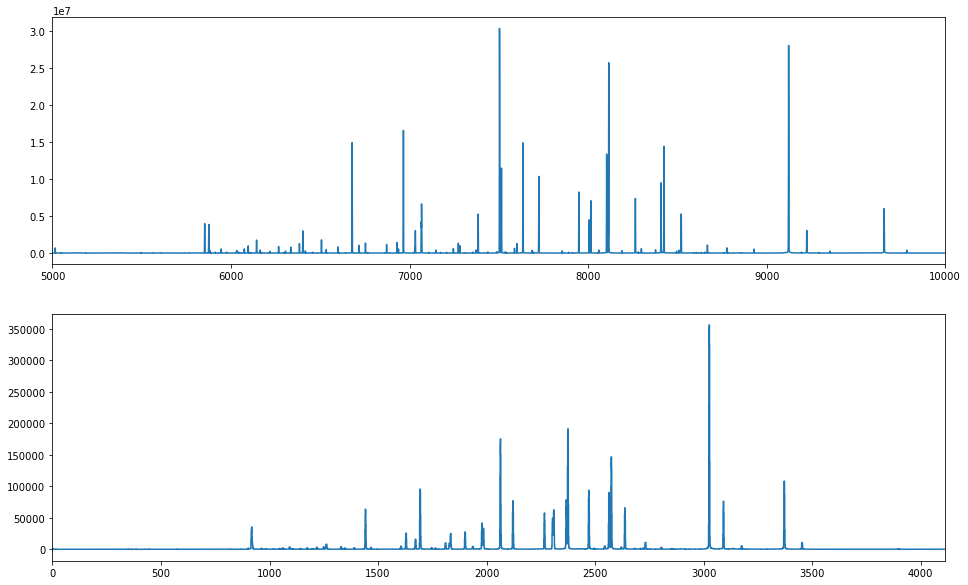

In [100]:
#first graph

#1D spec extraction from atlas lists/specs
fig, (ax1, ax2) = plt.subplots(2,1)#setting dimensions & locations of plots
ax1.plot(redwlnoao, redspecnoao) #atlas wl on x axis, atlas spec? on y axis
ax1.set_xlim(5000,10000) #x axis range to plot



#second graph - 1st arc lamp

#extracts 1D spec from arcimag and outputs line pixel to wl
#this one line is doing a dispersion solution to the:
#((data) that has overscan subtraction and trimming done to it and image flattened w/ (created above,normalized flat-rnfl), aperaturesize)
rds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl), (320, 360))
plt.axes(ax2) #plotting what the above line did
rds.plot_spec() #orders the 1D spec outputted above and uses plt to plot

print ('Want these to match for calibrating wavelengths - top is from atlas, bottom is an arc lamp')



In [101]:
#exploring the module, must call module then class then fcn to see what fcn does - like tree branches need bases

#help(reduce_dblspec.DispersionSolution.overscan_sub_and_trim)
#help(reduce_dblspec.DispersionSolution)
#help(reduce_dblspec)

In [102]:
#naming the overscanned & trimmed data image that is also flattened with prior created normalized flat
redarcimg15 = reduce_dblspec.DoubleSpecImage('20170518/red0017.fits').overscan_sub_and_trim().flatten(rnfl)

#naming the dispersion solution to (above line data, aperature dimensions, 3rd degree poly) 
rds = reduce_dblspec.DispersionSolution(redarcimg15, (320, 360), poly_order=3)

#want to guess line location(guess of peak line location, real wavelength of the line)
#returns slightly more accurate value for 1st input based on 2nd
rds.guess_line_loc(3372, 9657.78) #why these particular wavelengths/ what emission is this?
rds.guess_line_loc(3027, 9122.967)
rds.guess_line_loc(2375, 8115.31)
rds.guess_line_loc(2065, 7635.1)
rds.guess_line_loc(1630, 6965.43) 
#kinda confused by these b/c thought needs 4 inputs not 2-(minpeakrati, addtosoln) they dont seem necessary tho

#this runs thru atlas known spec lines & tries to match peaks to wl in specified range in ()
rds.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
#HENEAR_LINE_LIST is a list in reduce_dblspec module of wl values & associated element(s) name
#what is verbose?(wordiness?) - if it is output is found line
#how decided minpeakratio value-guess 10 is just a good low number but high enough to be above noise?
#peak to base ratio to do s/n (sigma) clip

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Tried to find peak at 2422.979481388916 but it's in a valley, not a peak"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 1.0426190628335574, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 7.738441232843095, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 lines
Failed to find line NeI at wl=8495.3598: "Guessed line's peak to base ratio is 6.927245602779625, which is less than 10"
Failed to find line KrI at wl=8508.87: "Guessed line's peak to base ratio is 0.918376926620163, which is less than 10"
Found line ArI at wl=8521.4422
Clipped 0 lines
Failed to find line NeI at wl=8591.2583: "Guessed line's peak to base ratio is 3.0391380134241954, which is less than 10

(20, 108)

aligning these graphs to check for overlap - top is dispersion soln(red), bottom is arc spec(blue) dispersion (red)


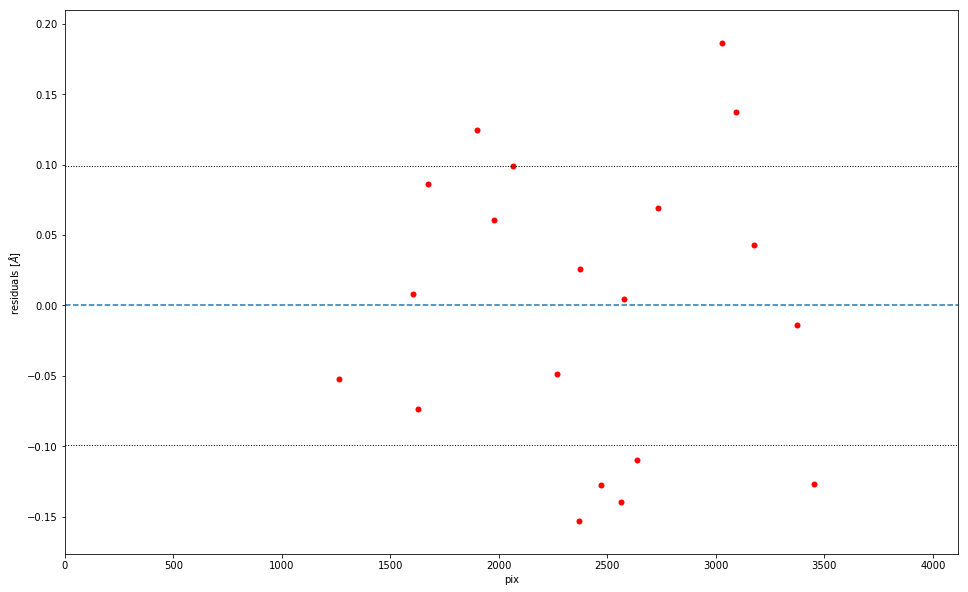

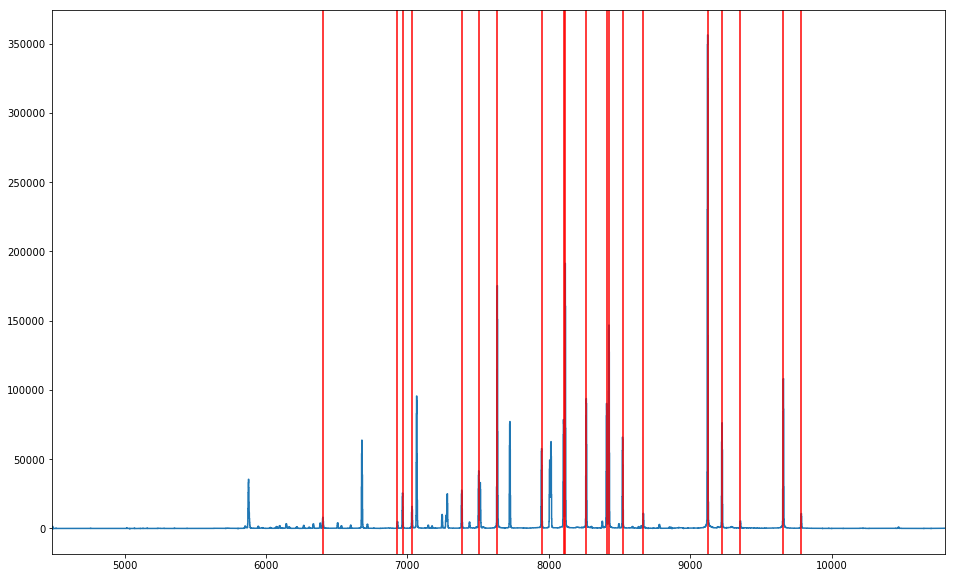

In [103]:
#1st graph
#need those guesses from guess_line_loc to run this
#scatter plots mins & maxs of red dispersion solution
rds.plot_solution(True) #plotsdres=true -- think that displays dashed line as standard residuals value 
plt.figure()

#2nd graph 
#plots 1D spec as a fcn of wavelength(blue) & dispersion min/maxs as red lines
rds.plot_spec_wl()

print ('aligning these graphs to check for overlap - top is dispersion soln(red), bottom is arc spec(blue) dispersion (red)')

### Collecting questions from this section
#### why choose these particular wavelengths/ what emissions are those / how determined guess values in 'guess_line_loc'?


## Red Dispersion (1.0")


/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


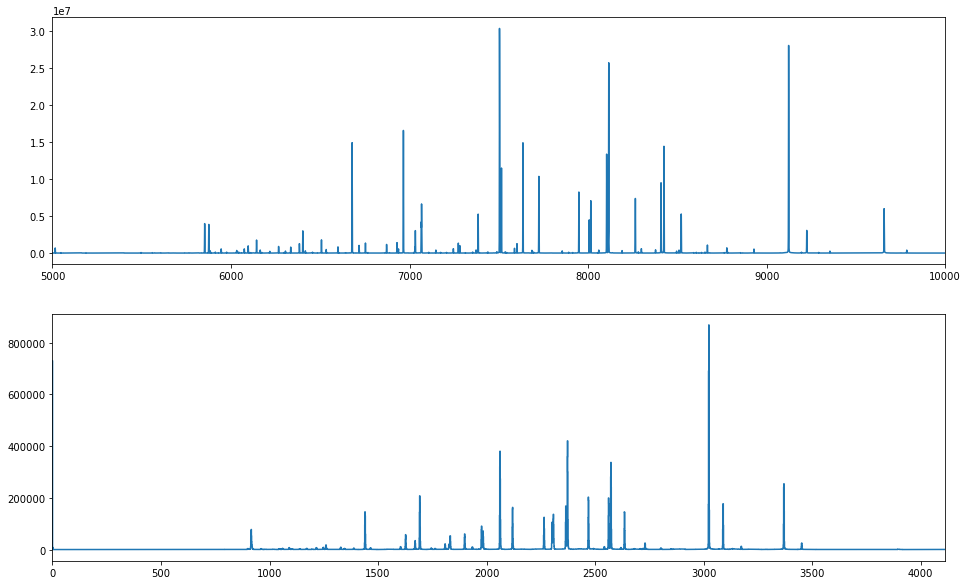

In [104]:
#first graph

#1D spec extraction from atlas lists/specs
fig, (ax1, ax2) = plt.subplots(2,1) #sets up graph dimensions
ax1.plot(redwlnoao, redspecnoao) #plotting wl on x axis, spec?? on y axis
ax1.set_xlim(5000,10000) #sets x axis range

#second graph

#same as above dispersion for 1.5"
#((data) that has overscan subtraction and trimming done to it and image flattened w/ (created above,normalized flat-rnfl), aperaturesize)
rds10 = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage('20170518/red0011.fits').overscan_sub_and_trim().flatten(rnfl), (130, 190))
plt.axes(ax2)
rds10.plot_spec() #orders the 1D spec outputted above and uses plt to plot

In [105]:
#same as for 1.5"

redarcimg10 = reduce_dblspec.DoubleSpecImage('20170518/red0011.fits').overscan_sub_and_trim().flatten(rnfl)
rds10 = reduce_dblspec.DispersionSolution(redarcimg10, (130, 190), poly_order=3)

rds10.guess_line_loc(3372, 9657.78)
rds10.guess_line_loc(3024, 9122.967)
rds10.guess_line_loc(2374, 8115.31)
rds10.guess_line_loc(2063, 7635.1)
rds10.guess_line_loc(1628, 6965.43)

rds10.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Failed to find line KrI at wl=7587.413: "Guessed line's peak to base ratio is 1.056730201650332, which is less than 10"
Failed to find line KrI at wl=7601.5443: "Guessed line's peak to base ratio is 1.1781804881195816, which is less than 10"
Found line ArI at wl=7635.106
Clipped 0 lines
Failed to find line KrI at wl=7685.246: "Guessed line's peak to base ratio is 1.0985644639321803, which is less than 10"
Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0038436845920389, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.9303030922578345, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 1.0642727390202864, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.036360099132756, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's p

(16, 112)

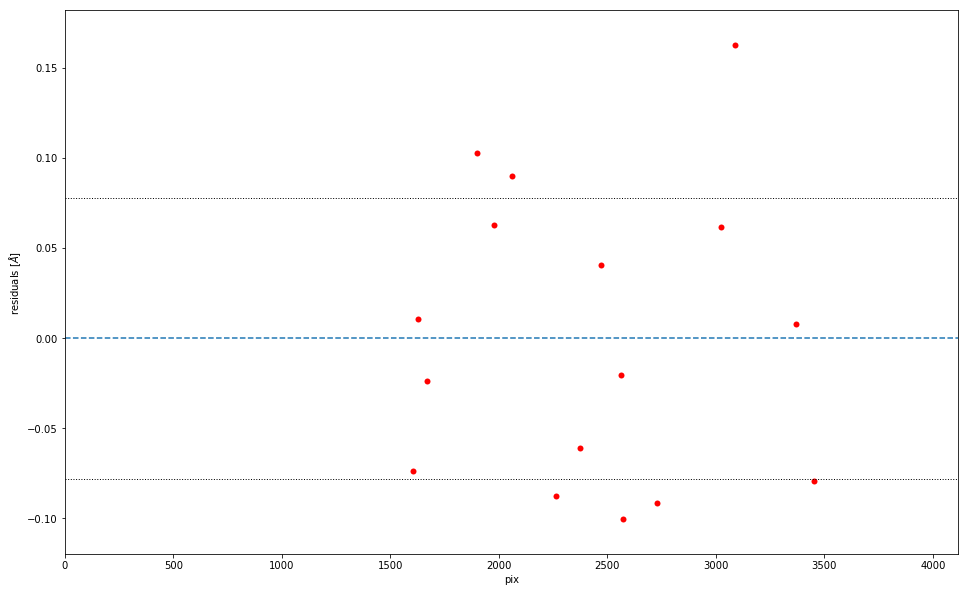

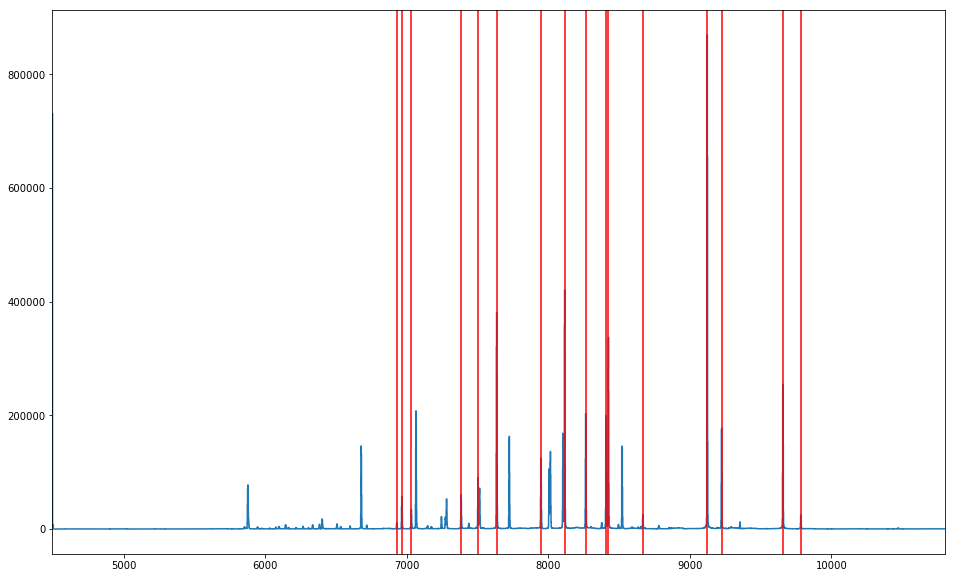

In [106]:
#same as for 1.5"

rds10.plot_solution(True)
plt.figure()
rds10.plot_spec_wl()

#### Compare the 1.0" and 1.5" solutions 

(1000, 3500)

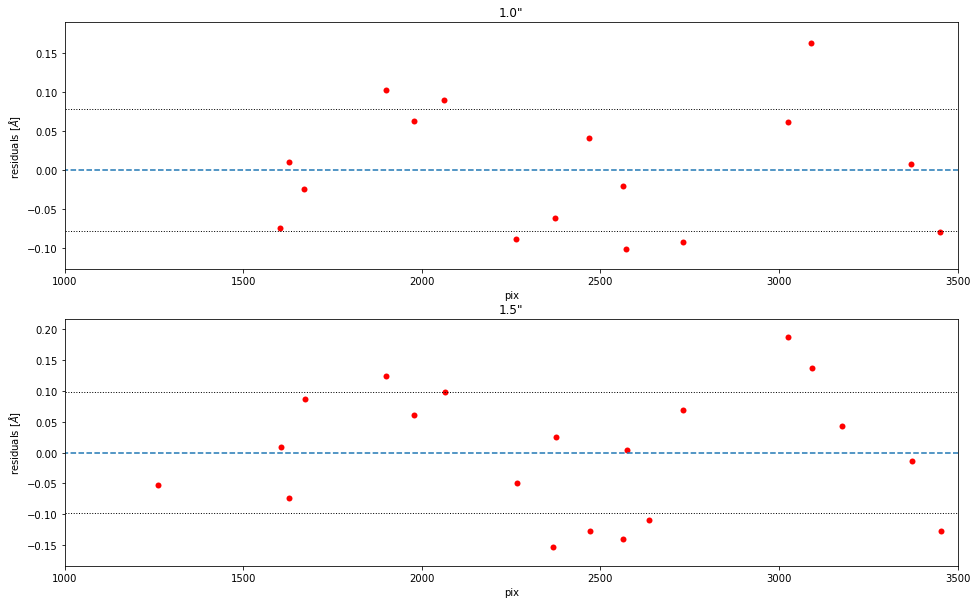

In [112]:
fix, (ax1, ax2) = plt.subplots(2,1)

#first graph - dispersion solution min/maxs for 1.0"
plt.axes(ax1)
rds10.plot_solution(True)
plt.title('1.0"')
plt.xlim(1000, 3500)

#second graph - dispersion solution min/maxs for 1.5"
plt.axes(ax2)
rds.plot_solution(True)
plt.title('1.5"')
plt.xlim(1000, 3500)